In [1]:
# ============================================================
# 03_modeling.ipynb
# Modeling for Mobility SLA Risk Prediction (Early Warning)
# ============================================================

# 0️⃣ Imports and paths
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

from config import PROCESSED_PATH, MODEL_PATH

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)

print("PROCESSED_PATH:", PROCESSED_PATH)
print("MODEL_PATH:", MODEL_PATH)


PROCESSED_PATH: /Users/loictiemani/Documents/sla-risk-prediction/data/processed/sla_cases_clean.csv
MODEL_PATH: /Users/loictiemani/Documents/sla-risk-prediction/models/sla_rf_model.pkl


In [2]:
# 1️⃣ Load processed feature dataset
df = pd.read_csv(PROCESSED_PATH)

TARGET_COL = "sla_breach"
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found."

print("Dataset shape:", df.shape)
print("Target distribution:")
display(df[TARGET_COL].value_counts())
display(df[TARGET_COL].value_counts(normalize=True).round(3))
df.head()


Dataset shape: (5000, 40)
Target distribution:


sla_breach
1    4629
0     371
Name: count, dtype: int64

sla_breach
1    0.926
0    0.074
Name: proportion, dtype: float64

,office_id,office_load,documents_missing,client_response_delay_days,reassignment_count,days_in_stage,sla_target_days,sla_breach,docs_per_sla,client_delay_per_sla,load_x_reassign,stage_time_ratio,is_urgent,case_type_Payroll,case_type_Relocation,case_type_Tax,case_type_Visa Renewal,case_type_Work Permit,country_CA,country_DE,country_UK,country_US,processing_stage_Decision,processing_stage_Documentation,processing_stage_Government Review,processing_stage_Intake,processing_stage_Submission,priority_Urgent,document_complexity_Low,document_complexity_Medium,missing_docs_bucket_1-2,missing_docs_bucket_3-4,missing_docs_bucket_5+,office_load_bucket_mid,office_load_bucket_high,office_load_bucket_very_high,client_delay_bucket_1-7,client_delay_bucket_8-14,client_delay_bucket_15-30,client_delay_bucket_30+
0,106,51,1,18,1,3,21,1,0.047619,0.857143,102,0.142857,0,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False,False,False,True,False
1,119,34,6,4,2,4,35,1,0.171429,0.114286,102,0.114286,0,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False
2,114,121,1,25,0,40,28,1,0.035714,0.892857,121,1.428571,1,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,True,False,False,False,False,True,False,False,True,False
3,110,94,2,4,0,33,30,1,0.066667,0.133333,94,1.100000,0,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,True,False,True,False,False,False
4,107,85,0,7,1,20,21,1,0.000000,0.333333,170,0.952381,0,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False


In [3]:
# 2️⃣ Train-test split (stratified)
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train breach rate:", round(y_train.mean(), 3), " Test breach rate:", round(y_test.mean(), 3))


Train shape: (4000, 39)  Test shape: (1000, 39)
Train breach rate: 0.926  Test breach rate: 0.926


In [6]:
# 3️⃣ Baseline model: Logistic Regression (interpretable)
# Use class_weight='balanced' to handle imbalance.
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=None
)

log_reg.fit(X_train, y_train)

lr_pred = log_reg.predict(X_test)
lr_proba = log_reg.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print(classification_report(y_test, lr_pred, digits=3))
print("ROC AUC:", round(roc_auc_score(y_test, lr_proba), 3))
print("Average Precision (PR AUC):", round(average_precision_score(y_test, lr_proba), 3))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.735     0.973     0.837        74
           1      0.998     0.972     0.985       926

    accuracy                          0.972      1000
   macro avg      0.866     0.972     0.911      1000
weighted avg      0.978     0.972     0.974      1000

ROC AUC: 0.997
Average Precision (PR AUC): 1.0


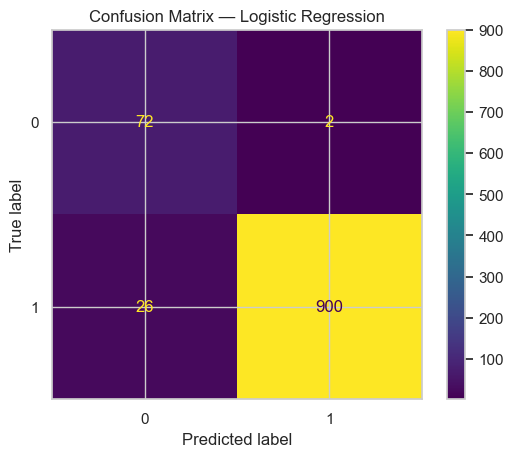

In [7]:
# Confusion matrix: Logistic Regression
cm = confusion_matrix(y_test, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix — Logistic Regression")
plt.show()


In [8]:
# 4️⃣ Tree model: Random Forest (strong performance + feature importance)
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced_subsample",
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, rf_pred, digits=3))
print("ROC AUC:", round(roc_auc_score(y_test, rf_proba), 3))
print("Average Precision (PR AUC):", round(average_precision_score(y_test, rf_proba), 3))


=== Random Forest ===
              precision    recall  f1-score   support

           0      0.847     0.824     0.836        74
           1      0.986     0.988     0.987       926

    accuracy                          0.976      1000
   macro avg      0.917     0.906     0.911      1000
weighted avg      0.976     0.976     0.976      1000

ROC AUC: 0.992
Average Precision (PR AUC): 0.999


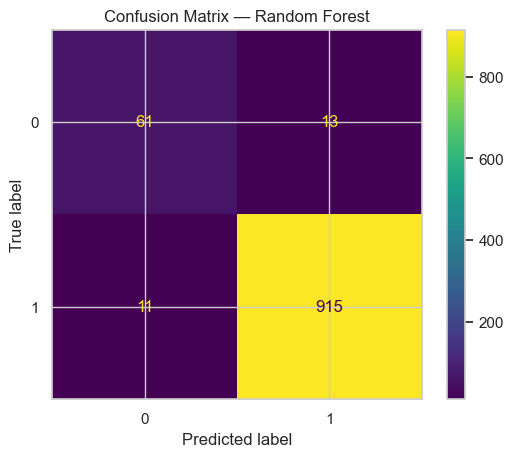

In [9]:

# Confusion matrix: Random Forest
cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix — Random Forest")
plt.show()


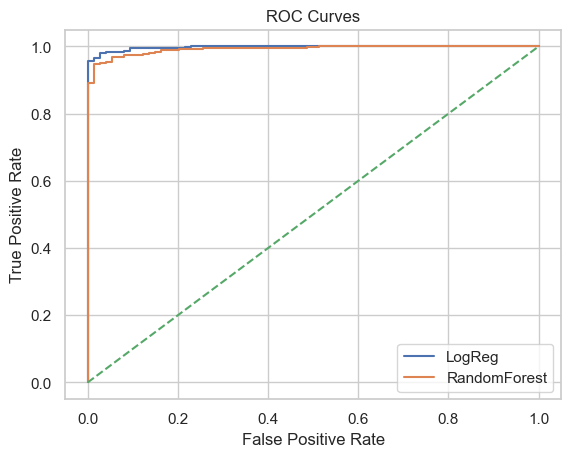

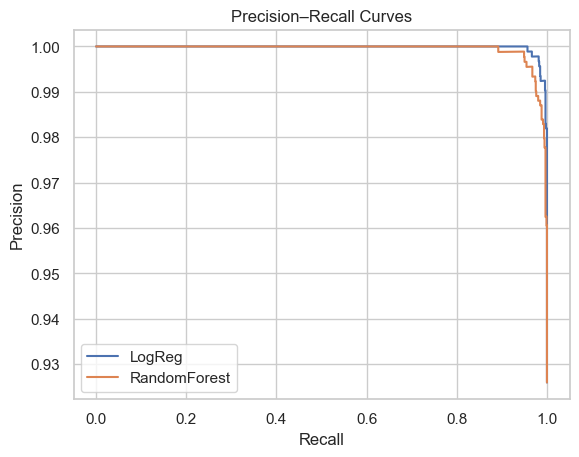

In [10]:
# 5️⃣ ROC & Precision-Recall curves (compare models)

# ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label="LogReg")
plt.plot(fpr_rf, tpr_rf, label="RandomForest")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# Precision-Recall
prec_lr, rec_lr, _ = precision_recall_curve(y_test, lr_proba)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, rf_proba)

plt.figure()
plt.plot(rec_lr, prec_lr, label="LogReg")
plt.plot(rec_rf, prec_rf, label="RandomForest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.show()


In [11]:
# 6️⃣ Pick a decision threshold (Early Warning)
# Default threshold is 0.5, but in operations you often want higher recall (catch risky cases).
# Let's pick a threshold that achieves ~0.80 recall (or closest).

thresholds = np.linspace(0.05, 0.95, 19)
results = []

for t in thresholds:
    pred_t = (rf_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred_t).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    results.append((t, precision, recall, fp, fn))

res_df = pd.DataFrame(results, columns=["threshold", "precision", "recall", "false_positives", "false_negatives"])
display(res_df)

# Choose threshold with recall closest to 0.80
target_recall = 0.80
best_row = res_df.iloc[(res_df["recall"] - target_recall).abs().argsort()[:1]]
best_threshold = float(best_row["threshold"].values[0])

print("Selected threshold for early warning:", best_threshold)
display(best_row)


,threshold,precision,recall,false_positives,false_negatives
0,0.05,0.943935,1.000000,55,0
1,0.10,0.948770,1.000000,50,0
2,0.15,0.956612,1.000000,42,0
3,0.20,0.960581,1.000000,38,0
4,0.25,0.966492,0.996760,32,3
5,0.30,0.976720,0.996760,22,3
6,0.35,0.980810,0.993521,18,6
7,0.40,0.982906,0.993521,16,6
8,0.45,0.983906,0.990281,15,9
9,0.50,0.985991,0.988121,13,11


Selected threshold for early warning: 0.95


,threshold,precision,recall,false_positives,false_negatives
18,0.95,1.0,0.885529,0,106


Top 20 features:


sla_target_days                       0.284045
client_delay_per_sla                  0.181849
stage_time_ratio                      0.156118
docs_per_sla                          0.115497
case_type_Relocation                  0.026367
client_response_delay_days            0.024677
case_type_Visa Renewal                0.024374
load_x_reassign                       0.023424
case_type_Tax                         0.020986
case_type_Work Permit                 0.018181
days_in_stage                         0.017035
office_load                           0.013278
documents_missing                     0.009741
reassignment_count                    0.009640
case_type_Payroll                     0.009444
office_id                             0.009308
client_delay_bucket_15-30             0.007944
processing_stage_Government Review    0.007599
document_complexity_Low               0.005467
client_delay_bucket_1-7               0.003465
dtype: float64

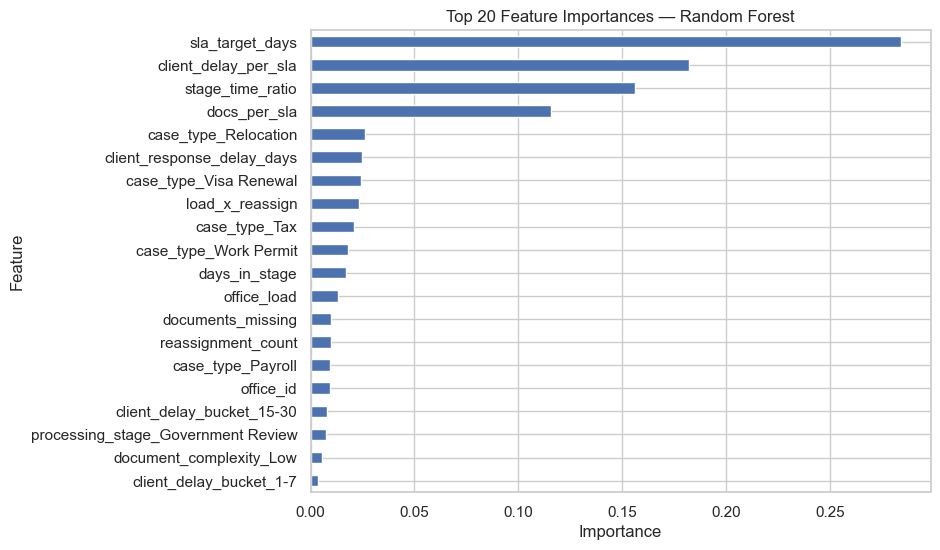

In [12]:
# 7️⃣ Feature importance (Random Forest)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("Top 20 features:")
display(importances.head(20))

plt.figure(figsize=(8,6))
importances.head(20).sort_values().plot(kind="barh")
plt.title("Top 20 Feature Importances — Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [13]:
# 8️⃣ Save the model (Random Forest) + metadata
# Save both model and the chosen threshold so you can use it later.

artifact = {
    "model": rf,
    "threshold": best_threshold,
    "feature_columns": list(X.columns),
    "target_col": TARGET_COL,
    "notes": "Early-warning SLA breach model trained on synthetic mobility workflow dataset."
}

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
joblib.dump(artifact, MODEL_PATH)

print("✅ Model artifact saved to:", MODEL_PATH)




✅ Model artifact saved to: /Users/loictiemani/Documents/sla-risk-prediction/models/sla_rf_model.pkl


In [14]:
# 9️⃣ Example: scoring new cases (illustration)
# Here we score a few rows from X_test

sample = X_test.head(10).copy()
sample_proba = rf.predict_proba(sample)[:, 1]
sample_pred = (sample_proba >= best_threshold).astype(int)

out = pd.DataFrame({
    "predicted_risk": sample_proba,
    "predicted_breach": sample_pred,
    "actual_breach": y_test.loc[sample.index].values
}, index=sample.index)

display(out.sort_values("predicted_risk", ascending=False))



,predicted_risk,predicted_breach,actual_breach
3110,1.000000,1,1
2428,1.000000,1,1
767,1.000000,1,1
4627,1.000000,1,1
1925,1.000000,1,1
3950,1.000000,1,1
3213,1.000000,1,1
4856,0.993041,1,1
4019,0.989245,1,1
3135,0.984418,1,1
